In [99]:
import pandas as pd
from string import punctuation
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
import recordlinkage
from nltk.corpus import stopwords
import joblib
lemma = WordNetLemmatizer()


df = pd.read_csv('data/training_data.csv')
df['Category']=df['label'].replace({0:'TA',1:'Malware',2:'tool'})
df.rename(columns={'Name':'name'},inplace=True)

In [2]:
df.head()

,name,Description,label,Category
0,admin@338,G0018 admin@338 is a China-based cyber threat ...,0,TA
1,apt1,G0006 APT1 is a Chinese threat group that has ...,0,TA
2,apt12,G0005 APT12 is a threat group that has been at...,0,TA
3,apt16,G0023 APT16 is a China-based threat group that...,0,TA
4,apt17,G0025 APT17 is a China-based threat group that...,0,TA


In [3]:
df.shape

(253, 4)

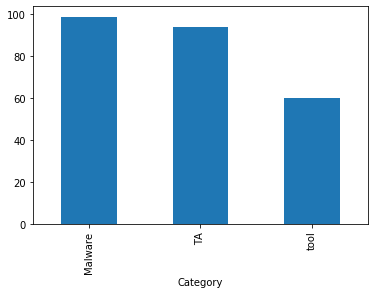

In [6]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(6,4))
df.groupby('Category').Description.count().plot.bar(ylim=0)
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default so

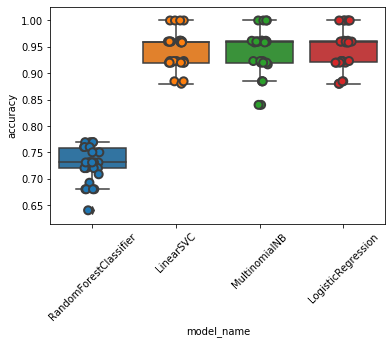

model_name
LinearSVC                 0.944705
LogisticRegression        0.947321
MultinomialNB             0.940752
RandomForestClassifier    0.727098
Name: accuracy, dtype: float64

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
import seaborn as sns

X=df['Description']
Y=df['Category']

count_vect = CountVectorizer(ngram_range=(1,2))
X_train_counts = count_vect.fit_transform(X)
tfidf_transformer = TfidfTransformer(sublinear_tf=True)
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0)
#     GradientBoostingClassifier(),
#     XGBClassifier(),
#     LGBMClassifier(),
#     CatBoostClassifier(verbose=0, n_estimators=100)
    
]
CV =  RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
entries=[]
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, X_train_counts, Y, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

graph =sns.boxplot(x='model_name', y='accuracy', data=cv_df)
graph = sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)

graph.set_xticklabels(graph.get_xticklabels(), rotation=45)
plt.show()
#print(cv_df)
cv_df.groupby('model_name').accuracy.mean()

(189, 16149)
0.703125


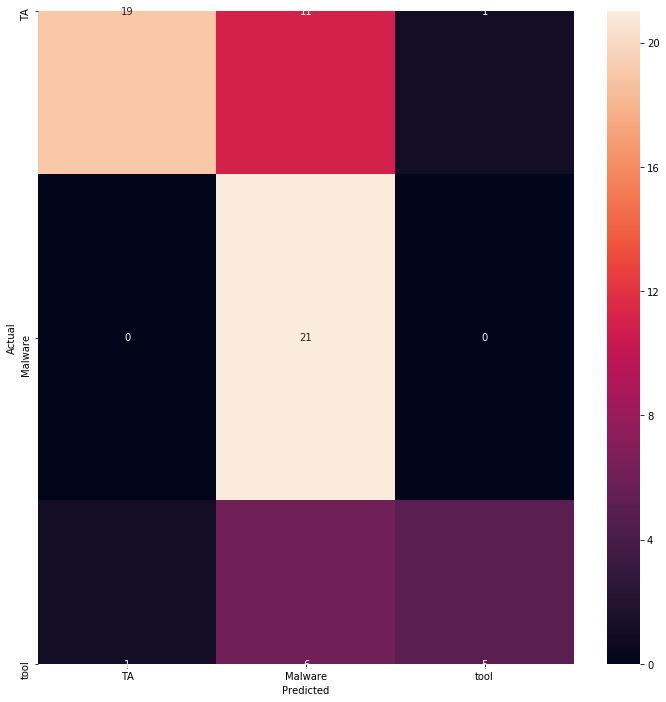

In [21]:
model = MultinomialNB()
X_train, X_test, y_train, y_test = train_test_split(df['Description'], df['Category'], random_state=0)

count_vect = CountVectorizer(ngram_range=(1,2),stop_words='english')
X_train_counts = count_vect.fit_transform(X_train)
X_test_counts =  count_vect.transform(X_test)
print(X_train_counts.shape)

# tfidf_transformer = TfidfTransformer(sublinear_tf=True)
# X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
# X_test_tfidf = tfidf_transformer.transform(X_test_counts)

model = model.fit(X_train_counts, y_train)
y_pred = model.predict(X_test_counts)

from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test,y_pred)
print(acc)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=df['Category'].unique(), yticklabels=df['Category'].unique())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

filename = 'multinomialNB.model'
filename1 = 'count_vect.model'
joblib.dump(model, open(filename, 'wb'))
joblib.dump(count_vect, open(filename1, 'wb'))

In [18]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names=df['Category'].unique()))

              precision    recall  f1-score   support

          TA       0.95      0.61      0.75        31
     Malware       0.55      1.00      0.71        21
        tool       0.83      0.42      0.56        12

    accuracy                           0.70        64
   macro avg       0.78      0.68      0.67        64
weighted avg       0.80      0.70      0.70        64



In [10]:
test_data=["""Dropping Elephant (also known as “Chinastrats” and “Patchwork“) is a relatively new threat actor that is targeting a variety of high profile diplomatic and economic targets using a custom set of attack tools. Its victims are all involved with China’s foreign relations in some way, and are generally caught through spear-phishing or watering hole attacks."""]

In [11]:
c = count_vect.transform(test_data)
#tfidf = tfidf_transformer.transform(c)
prediction=model.predict(c)

In [12]:
prediction

array(['TA'], dtype='<U7')

In [13]:
#function to preprocess th data
def text_preprocessing(df):
    stop_words = stopwords.words("english")+list(punctuation) # segregation stopwords and punctuations
    tokens=[]
    for index,row in df.iterrows():
        text = row['Description']
        words = [w.lower() for sent in nltk.sent_tokenize(str(text)) for w in nltk.word_tokenize(sent)] #applying tokenization
        words = [w for w in words if w not in stop_words and w.isalnum()] # removing stopwords and only alphanumeric
        words = [w for w in words if len(w)>1] #removing if length is less than 1
        words = [lemma.lemmatize(w,'v') for w in words ] # applying lemmatization
        df['Description'][index] = ' '.join(words)
        tokens.extend(words)
        
    return df

In [70]:
def probability_predictions(df_clean,prediction,test):
    
    if prediction == 'TA':
        df_check=df_clean[df['Category']=='TA']
    if prediction == 'Malware':
        df_check=df_clean[df['Category']=='Malware']
    if prediction == 'tool':   
        df_check=df_clean[df['Category']=='tool']
    if prediction == None:
        df_check = df_clean
        
    df_check=text_preprocessing(df_check)   
    df_check['ID'] = ['ID'+str(i) for i in range(len(df_check))]
    named_dict=dict()
    for index,row in df_check.iterrows():
        named_dict[row['ID']]= row['name']
        
    sentences=[]
    name=[]
    count=0
    for text in test:
        stop_words = stopwords.words("english")+list(punctuation)
        words = [w.lower() for sent in nltk.sent_tokenize(str(text)) for w in nltk.word_tokenize(sent)] #applying tokenization
        words = [w for w in words if w not in stop_words and w.isalnum()] # removing stopwords and only alphanumeric
        words = [w for w in words if len(w)>1] #removing if length is less than 1
        tokens = [lemma.lemmatize(w,'v')  for w in words]
        sentences.append(' '.join(tokens))
        name.append('ID_new'+str(count))
        count+=1
        
    df_test = pd.DataFrame({'ID':name,'Description':sentences})
    df_test.set_index('ID',inplace=True)
    df_check.set_index('ID',inplace=True)
        
    indexer = recordlinkage.Index()
    indexer.full()
    index_links = indexer.index(df_check, df_test)
    
    comp = recordlinkage.Compare()
    comp.string('Description', 'Description', method='jarowinkler',label='Distance')
    prob=comp.compute(index_links, df_check, df_test)
    
    result=prob.sort_values(['Distance'], ascending=True)
    result.reset_index(inplace=True)
    result.rename(columns={'ID_1':'Predicted','ID_2':'Actual'},inplace=True)

    result['Predicted'].replace(named_dict,inplace=True)
    return result

In [71]:
def class_prediction(model_path,count_vect_path,test,df):
    
    count=0
    model = joblib.load(model_path)
    count_vect = joblib.load(count_vect_path)
    for i in test:
        print(i)
        c = count_vect.transform([i])
        prediction=model.predict(c)
        print(prediction)
        result = probability_predictions(df_clean=df,prediction=prediction,test=[i])[0:5]
        if count==0:
            result_main = result
            count+=1
        else:
            reult_main = reult_main.append(result)
            
    return result
    

In [72]:
test_data=['The Sofacy Group (also known as APT28, Pawn Storm, Fancy Bear and Sednit) is a cyber espionage group believed to have ties to the Russian government. Likely operating since 2007, the group is known to target government, military, and security organizations. It has been characterized as an advanced persistent threat.']

In [73]:
class_prediction(model_path='model_weights/multinomialNB.model',count_vect_path='model_weights/count_vect.model',test=test_data,df=df)

The Sofacy Group (also known as APT28, Pawn Storm, Fancy Bear and Sednit) is a cyber espionage group believed to have ties to the Russian government. Likely operating since 2007, the group is known to target government, military, and security organizations. It has been characterized as an advanced persistent threat.
['TA']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


,Predicted,Actual,Distance
0,apt28,ID_new0,0.513958
1,apt41,ID_new0,0.515715
2,turla,ID_new0,0.517693
3,oilrig,ID_new0,0.518882
4,lazarus group,ID_new0,0.520261


In [152]:
test=['The Sofacy Group (also known as APT28, Pawn Storm, Fancy Bear and Sednit) is a cyber espionage group believed to have ties to the Russian government. Likely operating since 2007, the group is known to target government, military, and security organizations. It has been characterized as an advanced persistent threat.']

In [153]:
count_vect = CountVectorizer(ngram_range=(1,2),stop_words='english')
data = count_vect.fit_transform(df['Description'])

In [154]:
df_count=pd.DataFrame(data.todense(),columns=count_vect.vocabulary_.keys())
df_count['ID']=df['name']
df_count['Category']=df['Category']


In [155]:
prediction='TA'
df_clean=df_count

if prediction == 'TA':
        df_check=df_clean[df['Category']=='TA']
if prediction == 'Malware':
        df_check=df_clean[df['Category']=='Malware']
        
if prediction == 'tool':   
        df_check=df_clean[df['Category']=='tool']
        
if prediction == None:
        df_check = df_clean
df_check.set_index('ID',inplace=True)

In [156]:
test=count_vect.transform(test)
test=test.todense()
df_test = pd.DataFrame(test,columns=count_vect.vocabulary_)
df_test['ID'] = 'ID_NEW0'
df_test.set_index('ID',inplace=True)

In [157]:
indexer = recordlinkage.Index()
indexer.full()
index_links = indexer.index(df_check, df_test)

In [77]:
prediction='TA'
df_clean=df_count

if prediction == 'TA':
        df_check=df_clean[df['Category']=='TA']
if prediction == 'Malware':
        df_check=df_clean[df['Category']=='Malware']
        
if prediction == 'tool':   
        df_check=df_clean[df['Category']=='tool']
        
if prediction == None:
        df_check = df_clean
        
df_check=text_preprocessing(df_check)   
df_check['ID'] = ['ID'+str(i) for i in range(len(df_check))]
named_dict=dict()
for index,row in df_check.iterrows():
        named_dict[row['ID']]= row['name']
        
sentences=[]
name=[]
count=0
for text in test:
        stop_words = stopwords.words("english")+list(punctuation)
        words = [w.lower() for sent in nltk.sent_tokenize(str(text)) for w in nltk.word_tokenize(sent)] #applying tokenization
        words = [w for w in words if w not in stop_words and w.isalnum()] # removing stopwords and only alphanumeric
        words = [w for w in words if len(w)>1] #removing if length is less than 1
        tokens = [lemma.lemmatize(w,'v')  for w in words]
        sentences.append(' '.join(tokens))
        name.append('ID_new'+str(count))
        count+=1
        
df_test = pd.DataFrame({'ID':name,'Description':sentences})
df_test.set_index('ID',inplace=True)
df_check.set_index('ID',inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/use

In [170]:
indexer = recordlinkage.Index()
indexer.full()
index_links = indexer.index(df_check, df_test)
left_on=list(df_check.columns)
right_on=list(df_test.columns)
comp = recordlinkage.Compare()
comp.numeric(left_on=left_on,right_on=right_on)
prob=comp.compute(index_links, df_check, df_test)

TypeError: _compute_vectorized() takes 3 positional arguments but 40494 were given

In [84]:
golden_pairs=df_test
golden_matches_index = golden_pairs.index & index_links # 2093 matching pairs

In [86]:
logreg = recordlinkage.LogisticRegressionClassifier()
# Train the classifier
logreg.fit(golden_pairs, golden_matches_index)
print ("Intercept: ", logreg.intercept)
print ("Coefficients: ", logreg.coefficients)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


ValueError: could not convert string to float: 'sofacy group also know apt28 pawn storm fancy bear sednit cyber espionage group believe tie russian government likely operate since 2007 group know target government military security organizations characterize advance persistent threat'